# Distributed CBO -- Benchmark and Comparison

In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../..')

from dataclasses import dataclass
import math
import time
from typing import List

import matplotlib.pyplot as plt
import numpy as np

from cbx.dynamics import CBO, DistributedCBO, CommunicationType
from cbx.objectives import Rastrigin, Ackley, Michalewicz
import cbx.utils.termination as term

# CBO Configuration

In [2]:
conf = {
    'alpha': 40.0,
    'dt': 0.1,
    'sigma': 1.,
    'lamda': 1.0,
    'term_criteria': [term.max_it_term(100)],
    'track_args': {'names': ['update_norm', 'energy', 'x', 'consensus', 'drift']},

    'noise': 'anisotropic',
    'f_dim': '3D'
}

# Define Benchmarking Functions

In [3]:
import pandas as pd

results_df = pd.DataFrame(columns=['fct_name', 'dim', 'async_communication', 'max_particles', 'splt_factor', 'avg_energy', 'success_rate', 'num_func_evaluations', 'execution_time', 'comment'])

In [4]:
from scipy.optimize import minimize

def find_smallest_non_global_minimum(fun, dim, num_starts=1000):
    bounds = (-2, 2)
    global_min = 0  # The global minimum value of the Ackley function
    local_minima = []

    for _ in range(num_starts):
        # Random initial guess
        x0 = np.random.uniform(*bounds, dim)
        res = minimize(fun, x0, method='L-BFGS-B', bounds=[bounds] * dim)
        if res.success and not np.isclose(res.fun, global_min, atol=1e-6):
            local_minima.append(res.fun)
    
    # Find the smallest local minimum greater than the global minimum
    local_minima = np.array(local_minima)
    smallest_non_global = np.min(local_minima[local_minima > global_min])
    return smallest_non_global

In [5]:
find_smallest_non_global_minimum(Rastrigin(), 20, num_starts=10000)

np.float64(0.14924385856399863)

In [6]:
def benchmark_distributed_cbo_splitting_factor(
    f: callable,
    num_runs: int,
    max_splitting_factor: int,
    max_particles: int,
    synchronization_interval: int,
    synchronization_method: str,
    num_steps: int,
    use_async_communication: bool = False,
    axs=None,
    fmin: float = 0,
    success_eps: float = 1
):
    """
    Benchmarks the performance of the distributed Consensus-Based Optimization (CBO) algorithm 
    with varying splitting factors.
    Parameters:
    -----------
    f : callable
        The objective function to be minimized.
    num_runs : int
        The number of runs for each splitting factor.
    max_splitting_factor : int
        The maximum splitting factor to be tested.
    max_particles : int
        The maximum number of particles to be used in the optimization.
    synchronization_interval : int
        The interval at which synchronization occurs.
    synchronization_method : str
        The method used for synchronization.
    num_steps : int
        The number of optimization steps.
    use_async_communication : bool, optional
        Whether to use asynchronous communication (default is False).
    axs : matplotlib.axes.Axes, optional
        The axes on which to plot the results (default is None).
    fmin : float, optional
        The known minimum value of the objective function (default is 0).
    success_eps : float, optional
        The tolerance for considering the optimization successful (default is 1).
    Returns:
    --------
    int
        The splitting factor that resulted in the minimum average energy.
    Notes:
    ------
    This function runs the distributed CBO algorithm for different splitting factors, 
    measures the performance in terms of average energy, execution time, and success rate, 
    and plots the results if `axs` is provided.
    """
    dim = conf['d']
    communication_type = CommunicationType.ASYNC if use_async_communication else CommunicationType.SYNC
    
    energy_means = []
    execution_times = []
    function_evaluations = []
    quantile_10 = []
    quantile_90 = []
    success_rates = {splitting_factor: 0 for splitting_factor in range(1, max_splitting_factor + 1)}
    for splitting_factor in range(1, max_splitting_factor + 1):
        num_particles = math.ceil(max_particles / splitting_factor)
        current_energies = []
        for _ in range(num_runs):
            dyn = DistributedCBO(
                f=f,
                num_agent_batches=splitting_factor,
                synchronization_interval=synchronization_interval,
                synchronization_method=synchronization_method,
                communication_type=communication_type,
                N=num_particles,
                verbose=False,
                max_it=10000,
                **conf
            )

            # Run optimization and measure time
            tick = time.time()
            current_energies.append(
                f(dyn.optimize(num_steps=num_steps, sched='default'))
            )
            tock = time.time()
            execution_times.append(tock - tick)

            # Check if we found true minimum
            if abs(current_energies[-1] - fmin) < success_eps:
                success_rates[splitting_factor] += 1

            function_evaluations.append(dyn.num_f_eval())

        average_energy = np.mean(current_energies)
        average_function_evaluations = np.mean(function_evaluations)
        print(f"Splitting factor: {splitting_factor}, average energy: {average_energy}, success_rate: {success_rates[splitting_factor] / num_runs}, function evaluations: {average_function_evaluations}, execution time: {np.mean(execution_times)}")
        energy_means.append(average_energy)

        quantile_10.append(np.percentile(current_energies, 5))
        quantile_90.append(np.percentile(current_energies, 95))

        results_df.loc[len(results_df)] = [f.__class__.__name__, dim, use_async_communication, max_particles, splitting_factor, average_energy, success_rates[splitting_factor] / num_runs, average_function_evaluations, np.mean(execution_times), 'distributed CBO']

    if axs is not None:
        async_label = 'Async' if use_async_communication else 'Sync'
        axs.plot(list(range(1, max_splitting_factor + 1)), energy_means, label=f'Distributed CBO {async_label}')
        # Plot shaded confidence interval for energy from 10th to 90th percentile
        axs.fill_between(list(range(1, max_splitting_factor + 1)), quantile_10, quantile_90, alpha=0.3, label='90% CI')

    return int(np.argmin(energy_means) + 1)


In [7]:
def benchmark_distributed_cbo_synchronization_interval(
    f: callable,
    num_runs: int,
    synchronization_intervals: List[int],
    max_particles: int,
    splitting_factor: int,
    synchronization_method: str,
    num_steps: int,
    use_async_communication: bool = False,
    axs=None,
    fmin=0,
    success_eps: float = 1
):
    """
    Benchmarks the performance of the Distributed Consensus-Based Optimization (CBO) algorithm
    with varying synchronization intervals.

    Parameters:
    f (callable): The objective function to be minimized.
    num_runs (int): The number of runs to perform for each synchronization interval.
    synchronization_intervals (List[int]): A list of synchronization intervals to test.
    max_particles (int): The maximum number of particles to use in the optimization.
    splitting_factor (int): The factor by which the number of particles is split into batches.
    synchronization_method (str): The method used for synchronization (e.g., 'average', 'best').
    num_steps (int): The number of optimization steps to perform in each run.
    use_async_communication (bool, optional): Whether to use asynchronous communication. Defaults to False.
    axs (matplotlib.axes.Axes, optional): The axes on which to plot the results. Defaults to None.
    fmin (float, optional): The known minimum value of the objective function. Defaults to 0.
    success_eps (float, optional): The tolerance for considering an optimization run successful. Defaults to 1.

    Returns:
    None

    This function runs the Distributed CBO algorithm for each synchronization interval specified,
    measures the performance in terms of average energy, success rate, function evaluations, and execution time,
    and optionally plots the results on the provided axes.
    """
    communication_type = CommunicationType.ASYNC if use_async_communication else CommunicationType.SYNC

    energy_means = []
    execution_times = []
    function_evaluations = []
    quantile_10 = []
    quantile_90 = []
    success_rates = {synchronization_interval: 0 for synchronization_interval in synchronization_intervals}
    for synchronization_interval in synchronization_intervals:
        num_particles = math.ceil(max_particles / splitting_factor)
        current_energies = []
        for _ in range(num_runs):
            dyn = DistributedCBO(
                f=f,
                num_agent_batches=splitting_factor,
                synchronization_interval=synchronization_interval,
                synchronization_method=synchronization_method,
                communication_type=communication_type,
                N=num_particles,
                verbose=False,
                max_it=10000,
                **conf
            )

            # Run optimization and measure time
            tick = time.time()
            current_energies.append(
                f(dyn.optimize(num_steps=num_steps, sched='default'))
            )
            tock = time.time()
            execution_times.append(tock - tick)

            # Check if we found true minimum
            if abs(current_energies[-1] - fmin) < success_eps:
                success_rates[synchronization_interval] += 1

            function_evaluations.append(dyn.num_f_eval())

        average_energy = np.median(current_energies)
        average_function_evaluations = np.mean(function_evaluations)
        print(f"Synchronization interval: {synchronization_interval}, average energy: {average_energy}, success_rate: {success_rates[synchronization_interval] / num_runs}, function evaluations: {average_function_evaluations}, execution time: {np.mean(execution_times)}")
        energy_means.append(average_energy)

        quantile_10.append(np.percentile(current_energies, 5))
        quantile_90.append(np.percentile(current_energies, 95))

    if axs is not None:
        async_label = 'Async' if use_async_communication else 'Sync'
        axs.set_xscale('log')
        axs.plot(synchronization_intervals, energy_means, label=f'Distributed CBO {async_label}')
        # axs.set_xticks(synchronization_intervals)
        # Plot shaded confidence interval for energy from 10th to 90th percentile
        # axs.fill_between(synchronization_intervals, quantile_10, quantile_90, alpha=0.3, label='90% CI')


In [8]:
def benchmark_standard_cbo(
    f: callable,
    num_runs: int,
    num_particles: int,
    axs=None,
    fmin=0,
    success_eps: float = 1
):
    """
    Benchmarks the standard Consensus-Based Optimization (CBO) algorithm.

    Parameters:
    f (callable): The objective function to be minimized.
    num_runs (int): The number of runs to perform.
    num_particles (int): The number of particles in the CBO algorithm.
    axs (matplotlib.axes.Axes, optional): The axes on which to plot the results. Default is None.
    fmin (float, optional): The known minimum value of the objective function. Default is 0.
    success_eps (float, optional): The tolerance for considering a run successful. Default is 1.

    Returns:
    None

    The function prints the average energy, success rate, average function evaluations, and average execution time.
    It also appends the results to a global DataFrame `results_df` and optionally plots the mean energy and confidence interval.
    """
    dim = conf['d']

    energies = []
    execution_times = []
    function_evaluations = []
    quantile_10 = []
    quantile_90 = []
    success_rate = 0
    for _ in range(num_runs):
        dyn = CBO(
            f,
            N=num_particles,
            verbosity=0,
            max_it=10000,
            batch_args=None,
            M=1,
            **conf
        )

        # Run optimization and measure time
        tick = time.time()
        energies.append(
            f(dyn.optimize())
        )
        tock = time.time()
        execution_times.append(tock - tick)

        if abs(energies[-1] - fmin) < success_eps:
            success_rate += 1

        function_evaluations.append(dyn.num_f_eval)

    average_energy = np.median(energies)
    average_function_evaluations = np.mean(function_evaluations)
    print(f"Average energy: {average_energy}, success_rate: {success_rate / num_runs}, function evaluations: {average_function_evaluations}, execution time: {np.mean(execution_times)}")
    quantile_10.append(np.percentile(energies, 5))
    quantile_90.append(np.percentile(energies, 95))

    results_df.loc[len(results_df)] = [f.__class__.__name__, dim, False, num_particles, 1, average_energy, success_rate / num_runs, average_function_evaluations, np.mean(execution_times), 'standard CBO']

    # Plot mean of undistributed energies as a horizontal line
    if axs is not None:
        axs.axhline(y=average_energy, color='r', linestyle='--', label='Standard CBO')
        # Plot shaded confidence interval for energy from 10th to 90th percentile
        # axs.fill_between([0, 1], quantile_10, quantile_90, alpha=0.3, label='90% CI')


# Benchmark

In [9]:
# Benchmarking params
NUM_RUNS = 100
MAX_SPLITTING_FACTOR = 10
MAX_PARTICLES = 100
SYNCHRONIZATION_INTERVAL = 10
SYNCHRONIZATION_METHOD = 'weighted_mean'

In [10]:
success_epsilons = {}

In [11]:
def run_experiment(
    f: callable,
    d: int,
    n: int,
):
    """
    Runs a series of experiments to benchmark standard CBO and distributed CBO 
    (both synchronous and asynchronous communication) on a given function.
    Parameters:
    -----------
    f : callable
        The function to be optimized.
    d : int
        The dimensionality of the function.
    n : int
        The number of particles to be used in the optimization.
    Returns:
    --------
    None
    """
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))

    if (f.__class__.__name__, d) not in success_epsilons:
        success_eps = find_smallest_non_global_minimum(f, d)
        success_epsilons[(f.__class__.__name__, d)] = success_eps

    success_eps = success_epsilons[(f.__class__.__name__, d)]

    conf['d'] = d
    # Baseline (standard CBO)
    print("Standard CBO:")
    print("=============")
    benchmark_standard_cbo(
        f=f,
        num_runs=NUM_RUNS,
        num_particles=n,
        axs=axs[0],
        success_eps=success_eps
    )
    print()

    # Synchronous
    print("Distributed CBO (synchronous communication):")
    print("=============================================")
    best_splitting_factor_sync = benchmark_distributed_cbo_splitting_factor(
        f=f,
        use_async_communication=False,
        num_runs=NUM_RUNS,
        max_splitting_factor=MAX_SPLITTING_FACTOR,
        max_particles=n,
        synchronization_interval=SYNCHRONIZATION_INTERVAL,
        synchronization_method=SYNCHRONIZATION_METHOD,
        num_steps=100,
        axs=axs[0],
        success_eps=success_eps
    )
    print()

    # Asynchronous
    print("Distributed CBO (asynchronous communication):")
    print("==============================================")
    best_splitting_factor_async = benchmark_distributed_cbo_splitting_factor(
        f=f,
        use_async_communication=True,
        num_runs=NUM_RUNS,
        max_splitting_factor=MAX_SPLITTING_FACTOR,
        max_particles=n,
        synchronization_interval=SYNCHRONIZATION_INTERVAL,
        synchronization_method=SYNCHRONIZATION_METHOD,
        num_steps=100,
        axs=axs[0],
        success_eps=success_eps
    )
    print()

    function_label = f.__class__.__name__ + f" dim={d}"
    axs[0].set_xlabel(f"Splitting factor")
    axs[0].set_ylabel(f"Mean energy")
    axs[0].set_title(f"{function_label}\nsync interval: {SYNCHRONIZATION_INTERVAL}, sync method: {SYNCHRONIZATION_METHOD}, particles: {n}")
    axs[0].legend()

    ############################################################################

    # Baseline (standard CBO)
    print("Standard CBO:")
    print("=============")
    benchmark_standard_cbo(
        f=f,
        num_runs=NUM_RUNS,
        num_particles=n,
        axs=axs[1],
        success_eps=success_eps
    )
    print()

    # Synchronous
    print("Distributed CBO (synchronous communication):")
    print("=============================================")
    benchmark_distributed_cbo_synchronization_interval(
        f=f,
        use_async_communication=False,
        num_runs=NUM_RUNS,
        splitting_factor=best_splitting_factor_sync,
        max_particles=n,
        synchronization_intervals=[1, 10, 20, 30, 40, 50, 200],
        synchronization_method=SYNCHRONIZATION_METHOD,
        num_steps=100,
        axs=axs[1],
        success_eps=success_eps
    )
    print()

    # Asynchronous
    print("Distributed CBO (asynchronous communication):")
    print("==============================================")
    benchmark_distributed_cbo_synchronization_interval(
        f=f,
        use_async_communication=True,
        num_runs=NUM_RUNS,
        splitting_factor=best_splitting_factor_async,
        max_particles=n,
        synchronization_intervals=[1, 10, 20, 30, 40, 50, 200],
        synchronization_method=SYNCHRONIZATION_METHOD,
        num_steps=100,
        axs=axs[1],
        success_eps=success_eps
    )
    print()

    function_label = f.__class__.__name__ + f" dim={d}"
    axs[1].set_xlabel(f"Synchronization interval")
    axs[1].set_ylabel(f"Mean energy")
    axs[1].set_title(f"{function_label}\nsplitting factor (sync, async): {best_splitting_factor_sync, best_splitting_factor_async}, sync method: {SYNCHRONIZATION_METHOD}, particles: {n}")
    axs[1].legend()
    
    fig.show()

## Ackley, Rastrigin (d = 5, 10, 20; N = 50, 100, 200, 1000)

Ackley
Standard CBO:
Average energy: 0.015363929321605685, success_rate: 1.0, function evaluations: 5050.0, execution time: 0.006400494575500488

Distributed CBO (synchronous communication):
Splitting factor: 1, average energy: 0.023122433950600527, success_rate: 1.0, function evaluations: 5050.0, execution time: 0.013281166553497314
Splitting factor: 2, average energy: 0.023117468429980317, success_rate: 1.0, function evaluations: 5050.0, execution time: 0.0179325270652771
Splitting factor: 3, average energy: 0.025623021634480613, success_rate: 1.0, function evaluations: 5083.666666666667, execution time: 0.020515565077463785
Splitting factor: 4, average energy: 0.02923963883702063, success_rate: 1.0, function evaluations: 5125.75, execution time: 0.022734838724136352
Splitting factor: 5, average energy: 0.03998641543368235, success_rate: 1.0, function evaluations: 5110.6, execution time: 0.02546433973312378
Splitting factor: 6, average energy: 0.037646511019688925, success_rate: 1.0,

/var/folders/hm/3vrj0gkd6vlf68r7t8sqs86m0000gp/T/ipykernel_19112/3178628308.py:136: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Average energy: 0.17481868496931555, success_rate: 0.75, function evaluations: 5050.0, execution time: 0.006123194694519043

Distributed CBO (synchronous communication):
Splitting factor: 1, average energy: 0.20391237168408413, success_rate: 0.81, function evaluations: 5050.0, execution time: 0.0128859281539917
Splitting factor: 2, average energy: 0.11862947464315837, success_rate: 0.92, function evaluations: 5050.0, execution time: 0.013782426118850707
Splitting factor: 3, average energy: 0.08427783074882454, success_rate: 0.97, function evaluations: 5083.666666666667, execution time: 0.016216304302215576
Splitting factor: 4, average energy: 0.06817803810567731, success_rate: 0.99, function evaluations: 5125.75, execution time: 0.01938535988330841
Splitting factor: 5, average energy: 0.07944997863567199, success_rate: 0.97, function evaluations: 5110.6, execution time: 0.02241469383239746
Splitting factor: 6, average energy: 0.07894870255188766, success_rate: 0.98, function evaluation

/var/folders/hm/3vrj0gkd6vlf68r7t8sqs86m0000gp/T/ipykernel_19112/3178628308.py:136: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


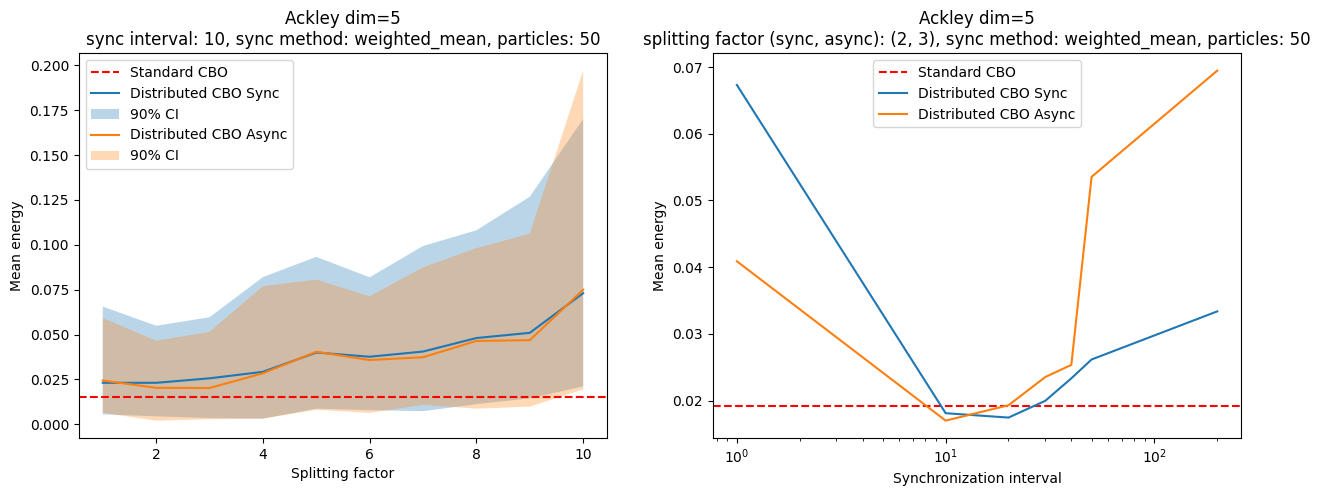

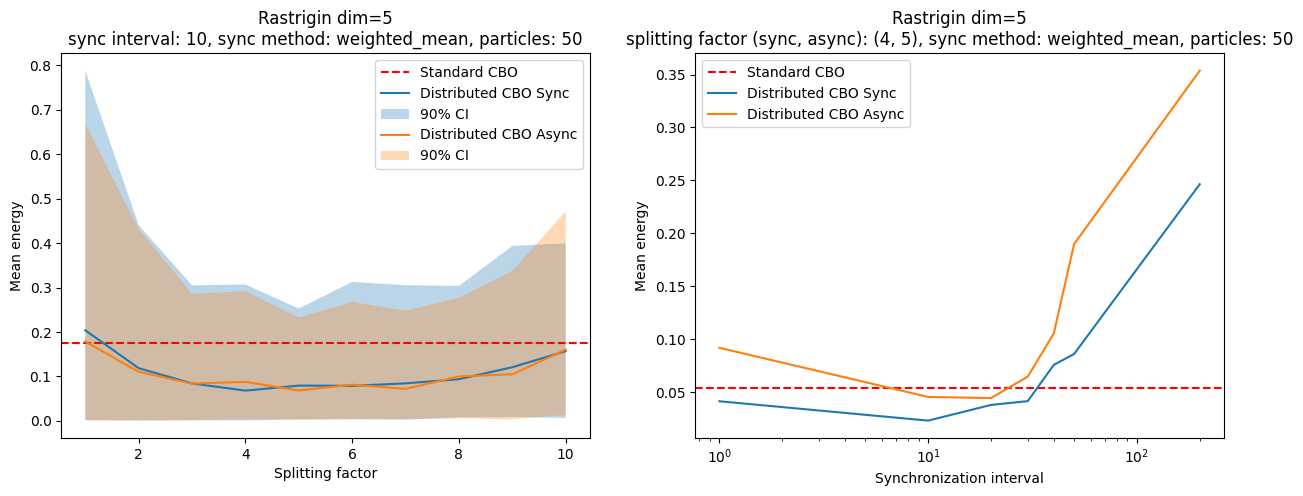

In [12]:
print("Ackley")
run_experiment(Ackley(), d=5, n=50)

print("Rastrigin")
run_experiment(Rastrigin(), d=5, n=50)

Ackley
Standard CBO:
Average energy: 0.13066921820272137, success_rate: 1.0, function evaluations: 5050.0, execution time: 0.007106301784515381

Distributed CBO (synchronous communication):
Splitting factor: 1, average energy: 0.16207728689748016, success_rate: 1.0, function evaluations: 5050.0, execution time: 0.013908793926239013
Splitting factor: 2, average energy: 0.13325395868243528, success_rate: 1.0, function evaluations: 5050.0, execution time: 0.01504319667816162
Splitting factor: 3, average energy: 0.13639268656674663, success_rate: 1.0, function evaluations: 5083.666666666667, execution time: 0.017799317836761475
Splitting factor: 4, average energy: 0.1457322159149226, success_rate: 1.0, function evaluations: 5125.75, execution time: 0.021289237141609192
Splitting factor: 5, average energy: 0.1671447217458786, success_rate: 1.0, function evaluations: 5110.6, execution time: 0.024578709125518797
Splitting factor: 6, average energy: 0.1676639010686962, success_rate: 1.0, funct

/var/folders/hm/3vrj0gkd6vlf68r7t8sqs86m0000gp/T/ipykernel_19112/3178628308.py:136: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Average energy: 0.5076412736153595, success_rate: 0.55, function evaluations: 5050.0, execution time: 0.006870837211608887

Distributed CBO (synchronous communication):
Splitting factor: 1, average energy: 0.6023646588269717, success_rate: 0.64, function evaluations: 5050.0, execution time: 0.014083676338195801
Splitting factor: 2, average energy: 0.3845022832654199, success_rate: 0.88, function evaluations: 5050.0, execution time: 0.014887081384658813
Splitting factor: 3, average energy: 0.4147084369745967, success_rate: 0.8, function evaluations: 5083.666666666667, execution time: 0.017378334999084474
Splitting factor: 4, average energy: 0.40540076144397524, success_rate: 0.78, function evaluations: 5125.75, execution time: 0.020378098487854004
Splitting factor: 5, average energy: 0.5124513503466871, success_rate: 0.71, function evaluations: 5110.6, execution time: 0.02343623971939087
Splitting factor: 6, average energy: 0.5726637272365158, success_rate: 0.6, function evaluations: 51

/var/folders/hm/3vrj0gkd6vlf68r7t8sqs86m0000gp/T/ipykernel_19112/3178628308.py:136: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


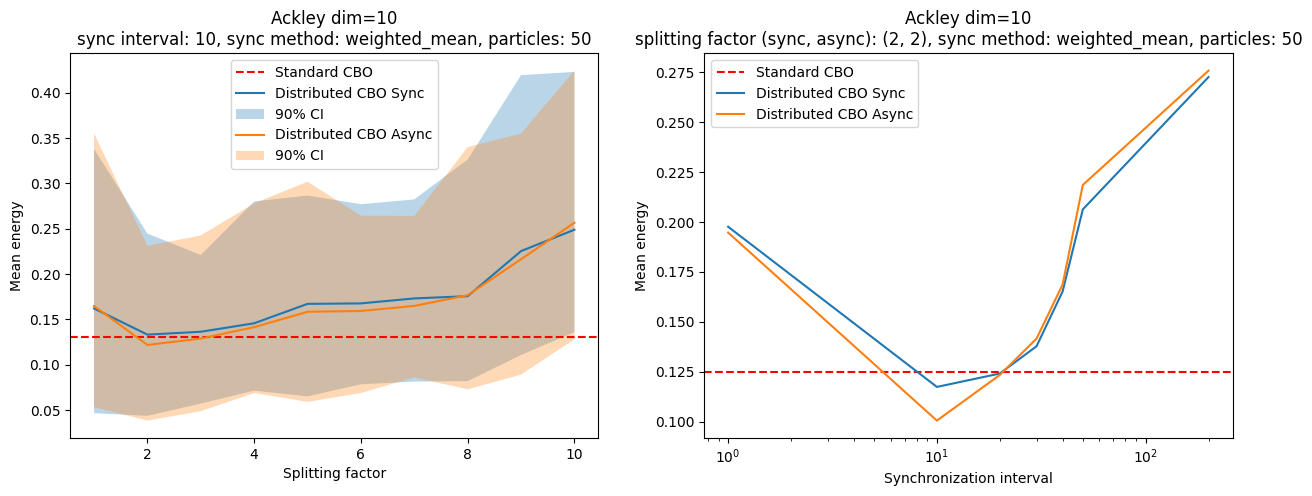

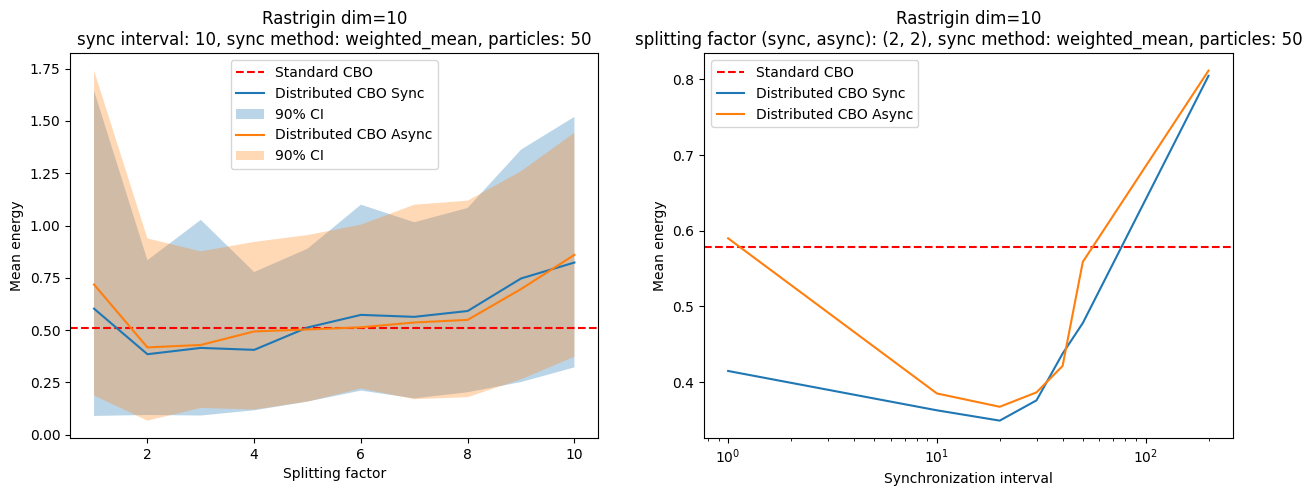

In [13]:
print("Ackley")
run_experiment(Ackley(), d=10, n=50)

print("Rastrigin")
run_experiment(Rastrigin(), d=10, n=50)

Ackley
Standard CBO:
Average energy: 0.45006868000449396, success_rate: 0.99, function evaluations: 5050.0, execution time: 0.008493216037750244

Distributed CBO (synchronous communication):
Splitting factor: 1, average energy: 0.4592708250256383, success_rate: 1.0, function evaluations: 5050.0, execution time: 0.015181069374084472
Splitting factor: 2, average energy: 0.3845860256034197, success_rate: 1.0, function evaluations: 5050.0, execution time: 0.016977447271347045
Splitting factor: 3, average energy: 0.36359328651146605, success_rate: 1.0, function evaluations: 5083.666666666667, execution time: 0.02002471446990967
Splitting factor: 4, average energy: 0.37878861216743476, success_rate: 1.0, function evaluations: 5125.75, execution time: 0.023193445205688477
Splitting factor: 5, average energy: 0.4163454122666014, success_rate: 1.0, function evaluations: 5110.6, execution time: 0.02649145793914795
Splitting factor: 6, average energy: 0.41625044016753987, success_rate: 1.0, funct

/var/folders/hm/3vrj0gkd6vlf68r7t8sqs86m0000gp/T/ipykernel_19112/3178628308.py:136: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Average energy: 1.6014511000945792, success_rate: 0.0, function evaluations: 5050.0, execution time: 0.008351821899414063

Distributed CBO (synchronous communication):
Splitting factor: 1, average energy: 1.7946127387271047, success_rate: 0.0, function evaluations: 5050.0, execution time: 0.015431942939758301
Splitting factor: 2, average energy: 1.3447173445658955, success_rate: 0.0, function evaluations: 5050.0, execution time: 0.016742372512817384
Splitting factor: 3, average energy: 1.2866249439303774, success_rate: 0.0, function evaluations: 5083.666666666667, execution time: 0.01972478707631429
Splitting factor: 4, average energy: 1.5088740529806421, success_rate: 0.0, function evaluations: 5125.75, execution time: 0.02306817948818207
Splitting factor: 5, average energy: 1.6292169454564893, success_rate: 0.0, function evaluations: 5110.6, execution time: 0.026145837306976318
Splitting factor: 6, average energy: 1.6557925357052201, success_rate: 0.0, function evaluations: 5167.8333

/var/folders/hm/3vrj0gkd6vlf68r7t8sqs86m0000gp/T/ipykernel_19112/3178628308.py:136: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


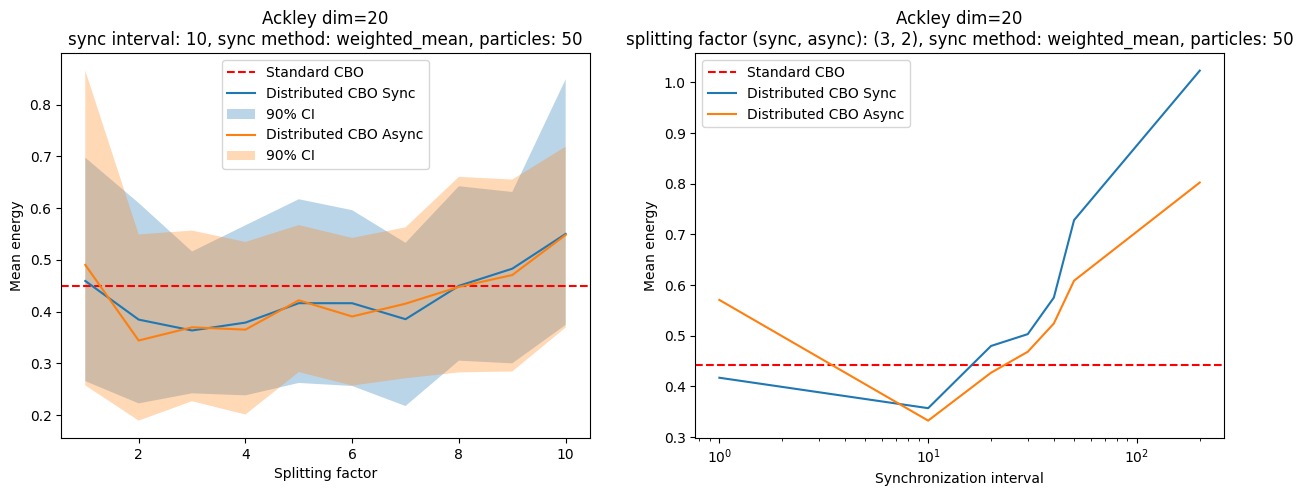

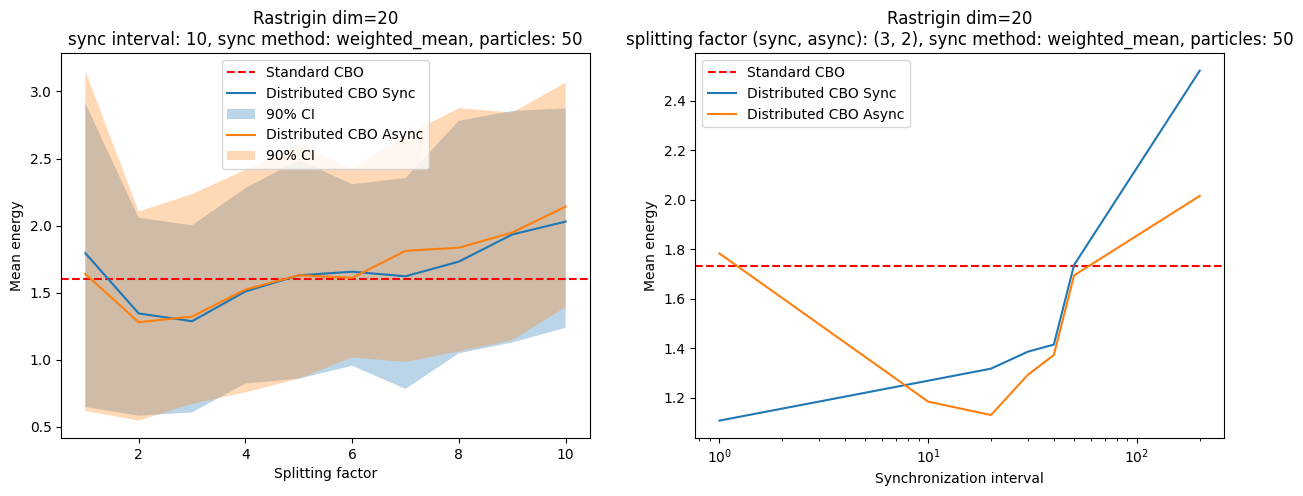

In [14]:
print("Ackley")
run_experiment(Ackley(), d=20, n=50)

print("Rastrigin")
run_experiment(Rastrigin(), d=20, n=50)

Ackley
Standard CBO:
Average energy: 0.011541875292124804, success_rate: 1.0, function evaluations: 10100.0, execution time: 0.007294771671295166

Distributed CBO (synchronous communication):
Splitting factor: 1, average energy: 0.012664827935012522, success_rate: 1.0, function evaluations: 10100.0, execution time: 0.014713358879089356
Splitting factor: 2, average energy: 0.010416738784402621, success_rate: 1.0, function evaluations: 10100.0, execution time: 0.016082212924957276
Splitting factor: 3, average energy: 0.010481567836869932, success_rate: 1.0, function evaluations: 10167.333333333334, execution time: 0.018996707598368325
Splitting factor: 4, average energy: 0.00995056154588008, success_rate: 1.0, function evaluations: 10150.5, execution time: 0.021915794610977174
Splitting factor: 5, average energy: 0.011541383239475511, success_rate: 1.0, function evaluations: 10140.4, execution time: 0.025121363639831543
Splitting factor: 6, average energy: 0.011271617677238393, success_r

/var/folders/hm/3vrj0gkd6vlf68r7t8sqs86m0000gp/T/ipykernel_19112/3178628308.py:136: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Average energy: 0.006264065073453296, success_rate: 0.95, function evaluations: 10100.0, execution time: 0.00703277587890625

Distributed CBO (synchronous communication):
Splitting factor: 1, average energy: 0.11040352058057822, success_rate: 0.92, function evaluations: 10100.0, execution time: 0.014649248123168946
Splitting factor: 2, average energy: 0.029067183753663614, success_rate: 1.0, function evaluations: 10100.0, execution time: 0.015839990377426148
Splitting factor: 3, average energy: 0.01981234260640518, success_rate: 1.0, function evaluations: 10167.333333333334, execution time: 0.018725274403889974
Splitting factor: 4, average energy: 0.012394889558972227, success_rate: 1.0, function evaluations: 10150.5, execution time: 0.021478432416915893
Splitting factor: 5, average energy: 0.01618520036872171, success_rate: 1.0, function evaluations: 10140.4, execution time: 0.024464104652404787
Splitting factor: 6, average energy: 0.010745159951733235, success_rate: 1.0, function eva

/var/folders/hm/3vrj0gkd6vlf68r7t8sqs86m0000gp/T/ipykernel_19112/3178628308.py:136: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


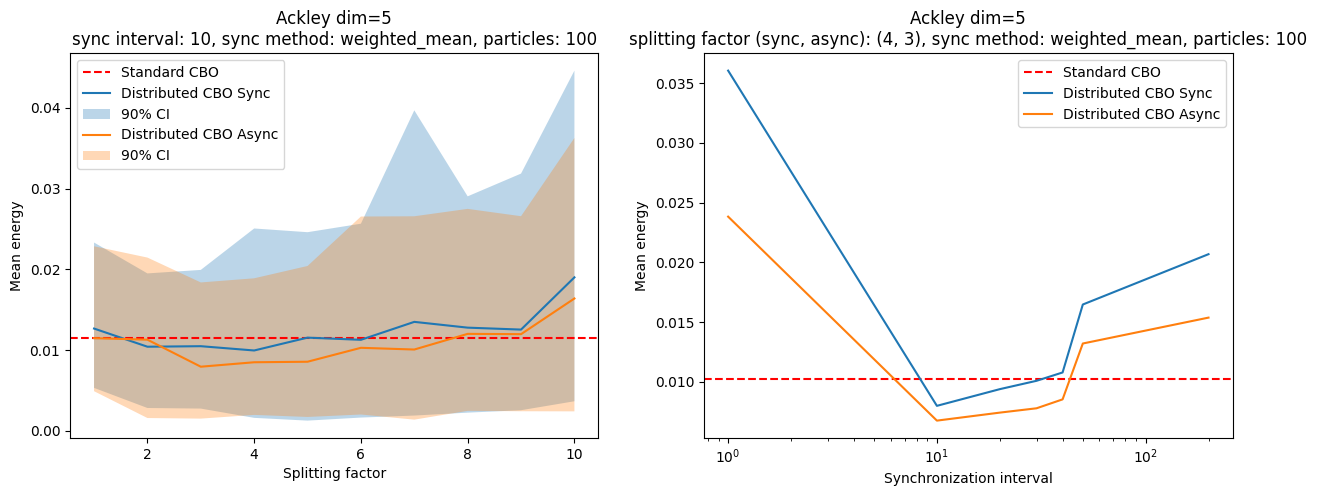

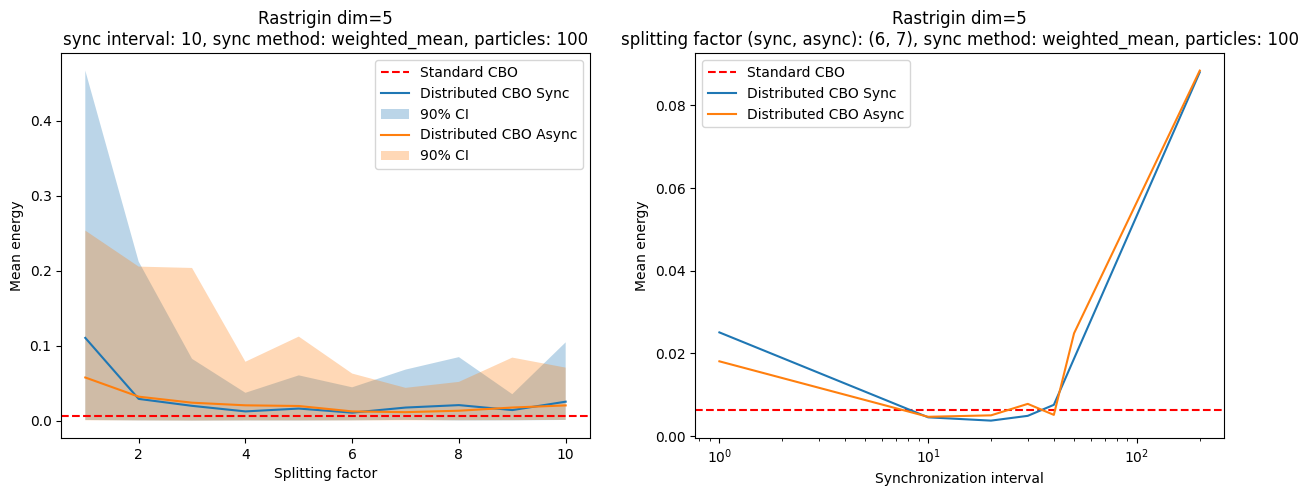

In [15]:
print("Ackley")
run_experiment(Ackley(), d=5, n=100)

print("Rastrigin")
run_experiment(Rastrigin(), d=5, n=100)

Ackley
Standard CBO:
Average energy: 0.05687897388165064, success_rate: 1.0, function evaluations: 10100.0, execution time: 0.008647613525390625

Distributed CBO (synchronous communication):
Splitting factor: 1, average energy: 0.061481680249486775, success_rate: 1.0, function evaluations: 10100.0, execution time: 0.015893681049346922
Splitting factor: 2, average energy: 0.05036775897075177, success_rate: 1.0, function evaluations: 10100.0, execution time: 0.017266844511032105
Splitting factor: 3, average energy: 0.0557199668845946, success_rate: 1.0, function evaluations: 10167.333333333334, execution time: 0.02053781270980835
Splitting factor: 4, average energy: 0.06289874817010965, success_rate: 1.0, function evaluations: 10150.5, execution time: 0.023920838236808777
Splitting factor: 5, average energy: 0.06763792271485024, success_rate: 1.0, function evaluations: 10140.4, execution time: 0.027329773426055907
Splitting factor: 6, average energy: 0.07018071891803417, success_rate: 1.

/var/folders/hm/3vrj0gkd6vlf68r7t8sqs86m0000gp/T/ipykernel_19112/3178628308.py:136: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Average energy: 0.3084689658092198, success_rate: 0.78, function evaluations: 10100.0, execution time: 0.008401181697845459

Distributed CBO (synchronous communication):
Splitting factor: 1, average energy: 0.39666552932504145, success_rate: 0.73, function evaluations: 10100.0, execution time: 0.01651090621948242
Splitting factor: 2, average energy: 0.24193196002887032, success_rate: 0.94, function evaluations: 10100.0, execution time: 0.01779563307762146
Splitting factor: 3, average energy: 0.19238202892139072, success_rate: 0.98, function evaluations: 10167.333333333334, execution time: 0.02085577090581258
Splitting factor: 4, average energy: 0.2069117117496658, success_rate: 0.99, function evaluations: 10150.5, execution time: 0.023597108125686647
Splitting factor: 5, average energy: 0.23440186073253858, success_rate: 0.97, function evaluations: 10140.4, execution time: 0.026951085567474366
Splitting factor: 6, average energy: 0.2181896028823466, success_rate: 0.98, function evaluat

/var/folders/hm/3vrj0gkd6vlf68r7t8sqs86m0000gp/T/ipykernel_19112/3178628308.py:136: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


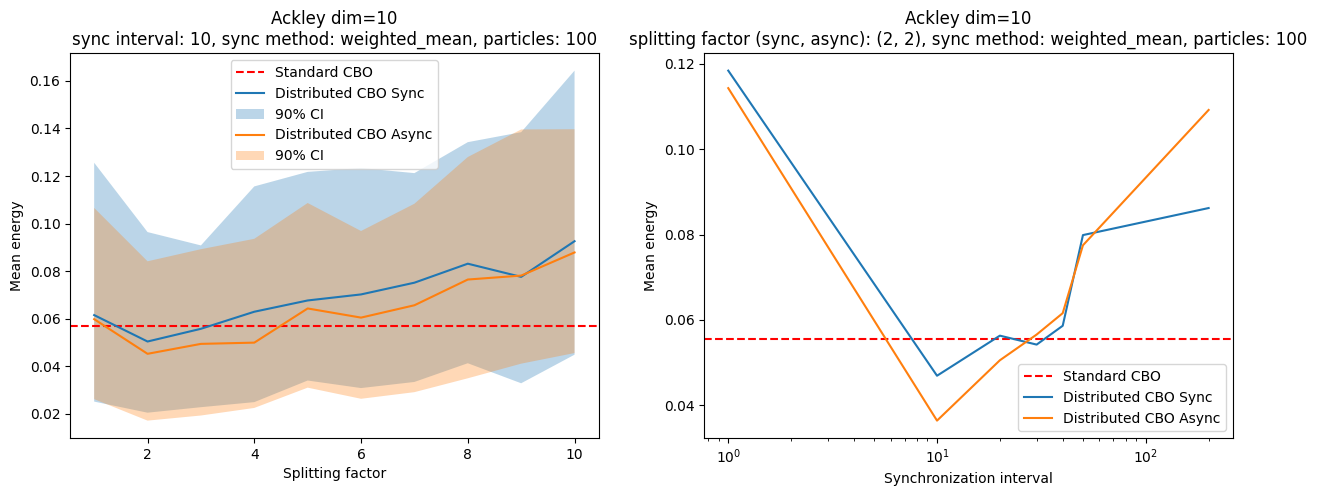

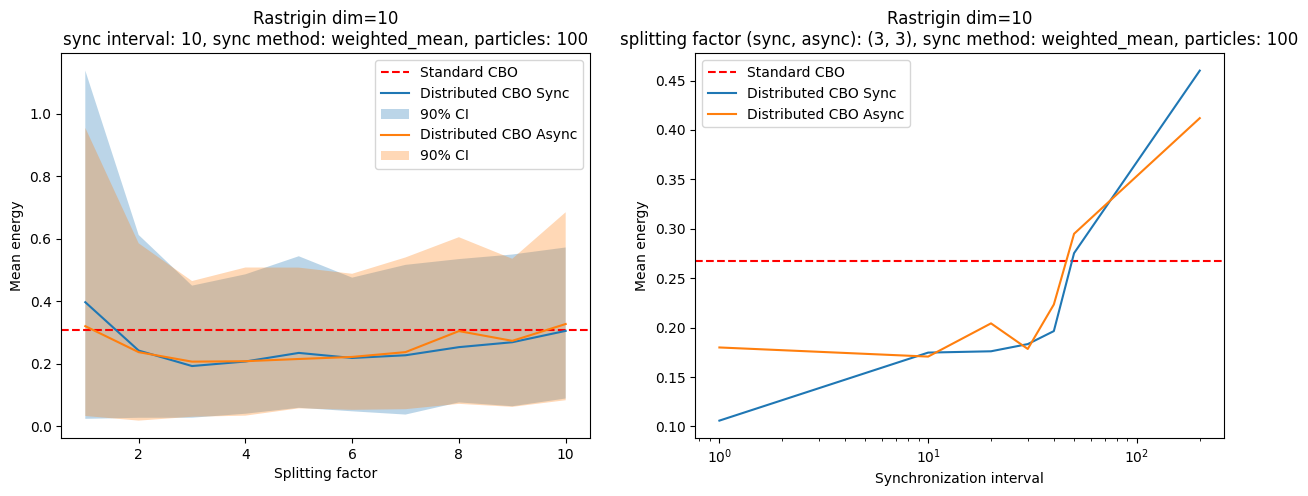

In [16]:
print("Ackley")
run_experiment(Ackley(), d=10, n=100)

print("Rastrigin")
run_experiment(Rastrigin(), d=10, n=100)

Ackley
Standard CBO:
Average energy: 0.21928401078237103, success_rate: 1.0, function evaluations: 10100.0, execution time: 0.010881927013397217

Distributed CBO (synchronous communication):
Splitting factor: 1, average energy: 0.247583820916016, success_rate: 1.0, function evaluations: 10100.0, execution time: 0.018169965744018555
Splitting factor: 2, average energy: 0.19583346963121695, success_rate: 1.0, function evaluations: 10100.0, execution time: 0.02012049198150635
Splitting factor: 3, average energy: 0.18807288381216314, success_rate: 1.0, function evaluations: 10167.333333333334, execution time: 0.02400360902150472
Splitting factor: 4, average energy: 0.19356517311292012, success_rate: 1.0, function evaluations: 10150.5, execution time: 0.0270083487033844
Splitting factor: 5, average energy: 0.1991373986661259, success_rate: 1.0, function evaluations: 10140.4, execution time: 0.030424540519714355
Splitting factor: 6, average energy: 0.20595930077502023, success_rate: 1.0, fun

/var/folders/hm/3vrj0gkd6vlf68r7t8sqs86m0000gp/T/ipykernel_19112/3178628308.py:136: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Average energy: 1.0005078363235582, success_rate: 0.0, function evaluations: 10100.0, execution time: 0.010841939449310303

Distributed CBO (synchronous communication):
Splitting factor: 1, average energy: 0.9781433024872573, success_rate: 0.0, function evaluations: 10100.0, execution time: 0.01783831834793091
Splitting factor: 2, average energy: 0.7109989798912418, success_rate: 0.0, function evaluations: 10100.0, execution time: 0.019990183115005493
Splitting factor: 3, average energy: 0.793619079062675, success_rate: 0.0, function evaluations: 10167.333333333334, execution time: 0.024030778408050537
Splitting factor: 4, average energy: 0.8336940377585812, success_rate: 0.0, function evaluations: 10150.5, execution time: 0.026946122646331786
Splitting factor: 5, average energy: 0.9222597727409743, success_rate: 0.0, function evaluations: 10140.4, execution time: 0.030309311866760252
Splitting factor: 6, average energy: 0.9222920294306111, success_rate: 0.0, function evaluations: 1016

/var/folders/hm/3vrj0gkd6vlf68r7t8sqs86m0000gp/T/ipykernel_19112/3178628308.py:136: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


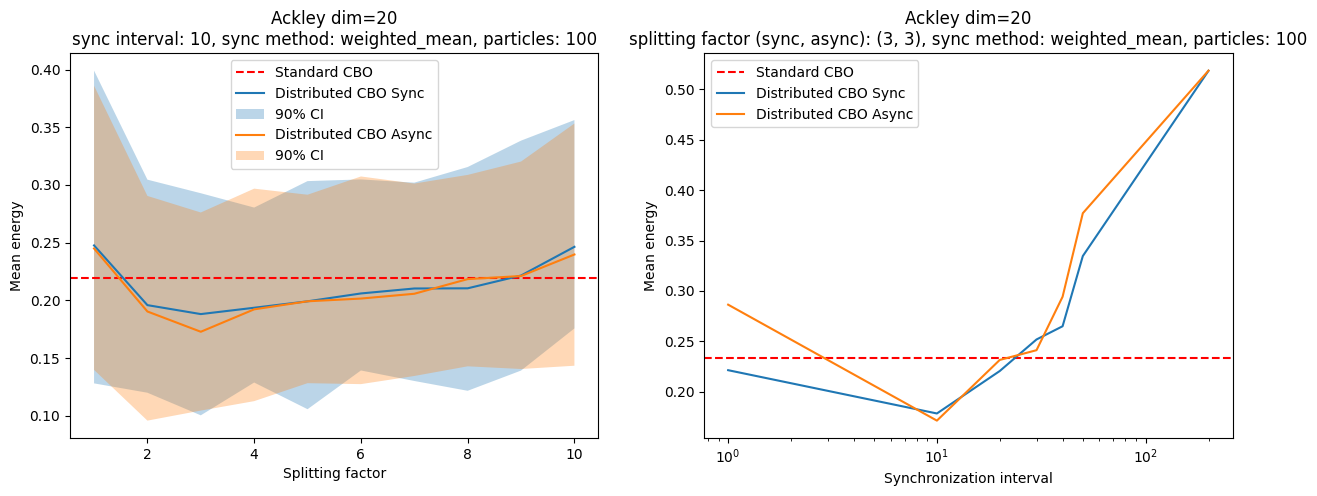

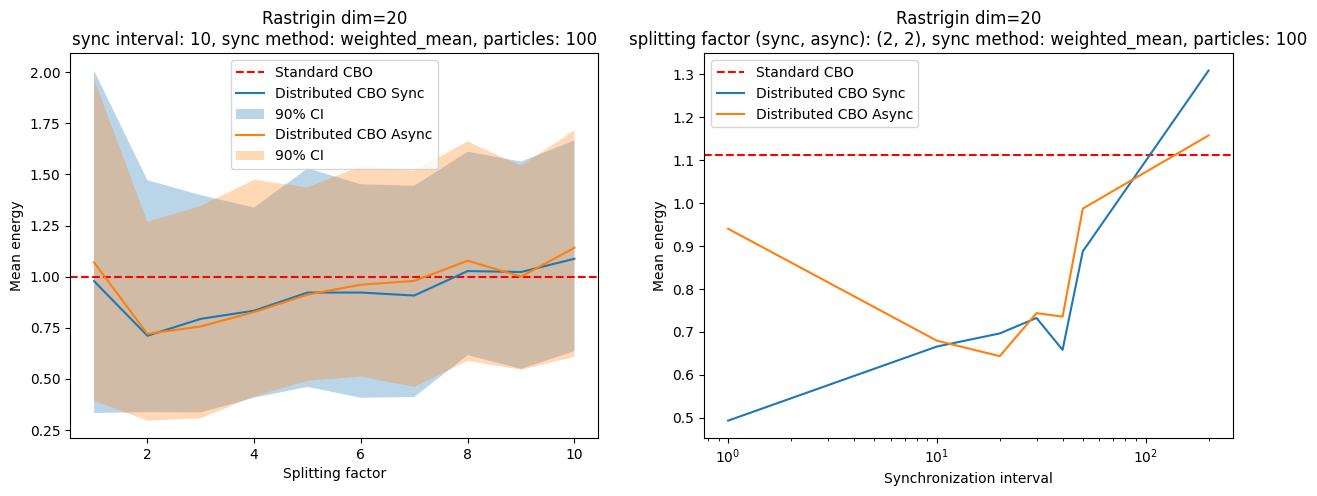

In [17]:
print("Ackley")
run_experiment(Ackley(), d=20, n=100)

print("Rastrigin")
run_experiment(Rastrigin(), d=20, n=100)

Ackley
Standard CBO:
Average energy: 0.007626003419009653, success_rate: 1.0, function evaluations: 20200.0, execution time: 0.008929855823516845

Distributed CBO (synchronous communication):
Splitting factor: 1, average energy: 0.007925840123096765, success_rate: 1.0, function evaluations: 20200.0, execution time: 0.015792667865753174
Splitting factor: 2, average energy: 0.007612738136641522, success_rate: 1.0, function evaluations: 20200.0, execution time: 0.017182464599609374
Splitting factor: 3, average energy: 0.006501565987393558, success_rate: 1.0, function evaluations: 20233.666666666668, execution time: 0.02039178927739461
Splitting factor: 4, average energy: 0.006030568012604096, success_rate: 1.0, function evaluations: 20225.25, execution time: 0.024380406737327574
Splitting factor: 5, average energy: 0.005482494866088725, success_rate: 1.0, function evaluations: 20220.2, execution time: 0.02797951078414917
Splitting factor: 6, average energy: 0.004757977621532721, success_r

/var/folders/hm/3vrj0gkd6vlf68r7t8sqs86m0000gp/T/ipykernel_19112/3178628308.py:136: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Average energy: 0.0037690609446334733, success_rate: 0.97, function evaluations: 20200.0, execution time: 0.009382812976837159

Distributed CBO (synchronous communication):
Splitting factor: 1, average energy: 0.016678120519113885, success_rate: 1.0, function evaluations: 20200.0, execution time: 0.01715853452682495
Splitting factor: 2, average energy: 0.00534211734366636, success_rate: 1.0, function evaluations: 20200.0, execution time: 0.017558174133300783
Splitting factor: 3, average energy: 0.0027258954782733835, success_rate: 1.0, function evaluations: 20233.666666666668, execution time: 0.020302786032358806
Splitting factor: 4, average energy: 0.004651201398500224, success_rate: 1.0, function evaluations: 20225.25, execution time: 0.023129359483718873
Splitting factor: 5, average energy: 0.0028747376675089882, success_rate: 1.0, function evaluations: 20220.2, execution time: 0.026623746395111083
Splitting factor: 6, average energy: 0.0015266433387061834, success_rate: 1.0, functi

/var/folders/hm/3vrj0gkd6vlf68r7t8sqs86m0000gp/T/ipykernel_19112/3178628308.py:136: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


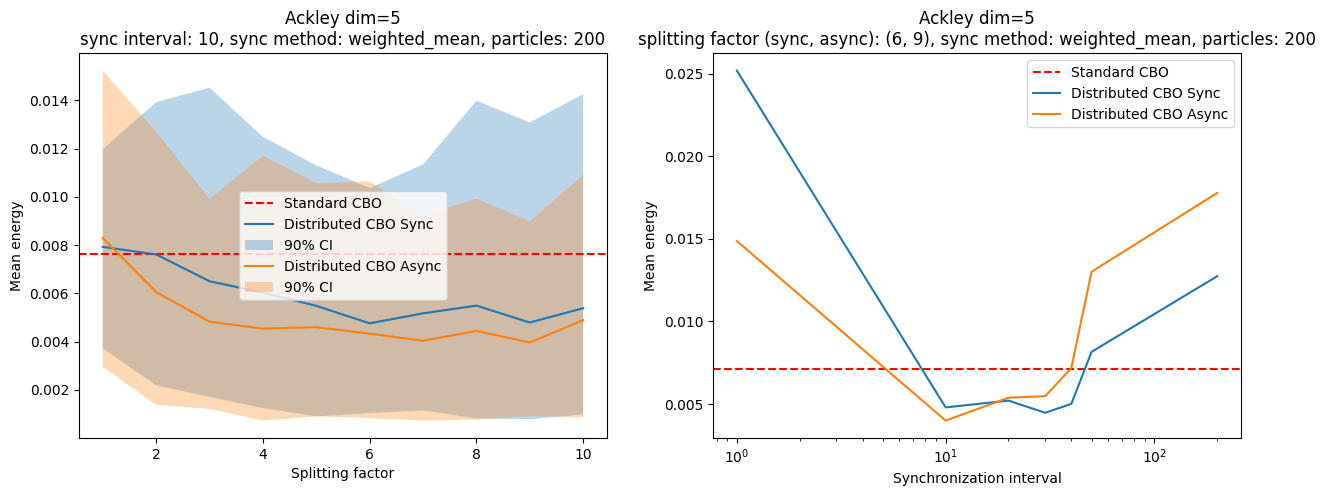

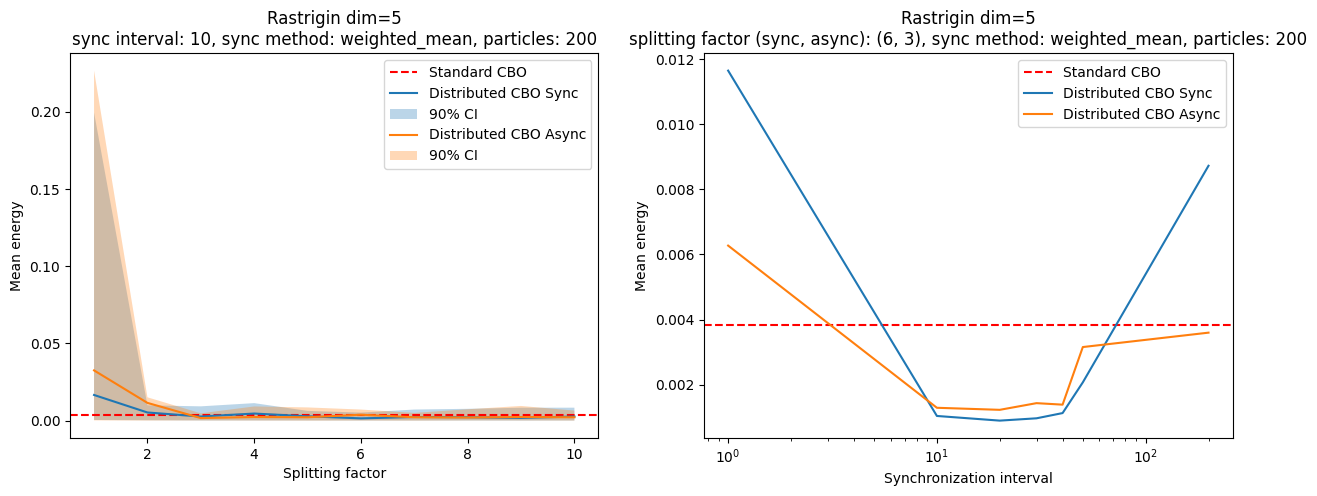

In [18]:
print("Ackley")
run_experiment(Ackley(), d=5, n=200)

print("Rastrigin")
run_experiment(Rastrigin(), d=5, n=200)

Ackley
Standard CBO:
Average energy: 0.03408061027254172, success_rate: 1.0, function evaluations: 20200.0, execution time: 0.011307115554809571

Distributed CBO (synchronous communication):
Splitting factor: 1, average energy: 0.0340384309154433, success_rate: 1.0, function evaluations: 20200.0, execution time: 0.01889505863189697
Splitting factor: 2, average energy: 0.030777996016459374, success_rate: 1.0, function evaluations: 20200.0, execution time: 0.020664284229278563
Splitting factor: 3, average energy: 0.02867593250575597, success_rate: 1.0, function evaluations: 20233.666666666668, execution time: 0.02440746307373047
Splitting factor: 4, average energy: 0.02787121515626458, success_rate: 1.0, function evaluations: 20225.25, execution time: 0.02762663543224335
Splitting factor: 5, average energy: 0.029393044278802325, success_rate: 1.0, function evaluations: 20220.2, execution time: 0.03127383232116699
Splitting factor: 6, average energy: 0.03187609615650766, success_rate: 1.0

/var/folders/hm/3vrj0gkd6vlf68r7t8sqs86m0000gp/T/ipykernel_19112/3178628308.py:136: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Average energy: 0.13410820736642598, success_rate: 0.92, function evaluations: 20200.0, execution time: 0.011078202724456787

Distributed CBO (synchronous communication):
Splitting factor: 1, average energy: 0.24606990473649382, success_rate: 0.91, function evaluations: 20200.0, execution time: 0.017883682250976564
Splitting factor: 2, average energy: 0.12476213972469488, success_rate: 0.99, function evaluations: 20200.0, execution time: 0.020286290645599364
Splitting factor: 3, average energy: 0.10837200274946104, success_rate: 1.0, function evaluations: 20233.666666666668, execution time: 0.024066917896270752
Splitting factor: 4, average energy: 0.09917255697366834, success_rate: 1.0, function evaluations: 20225.25, execution time: 0.02716241478919983
Splitting factor: 5, average energy: 0.08666273757911591, success_rate: 1.0, function evaluations: 20220.2, execution time: 0.03054886245727539
Splitting factor: 6, average energy: 0.08478747004185092, success_rate: 1.0, function evalua

/var/folders/hm/3vrj0gkd6vlf68r7t8sqs86m0000gp/T/ipykernel_19112/3178628308.py:136: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


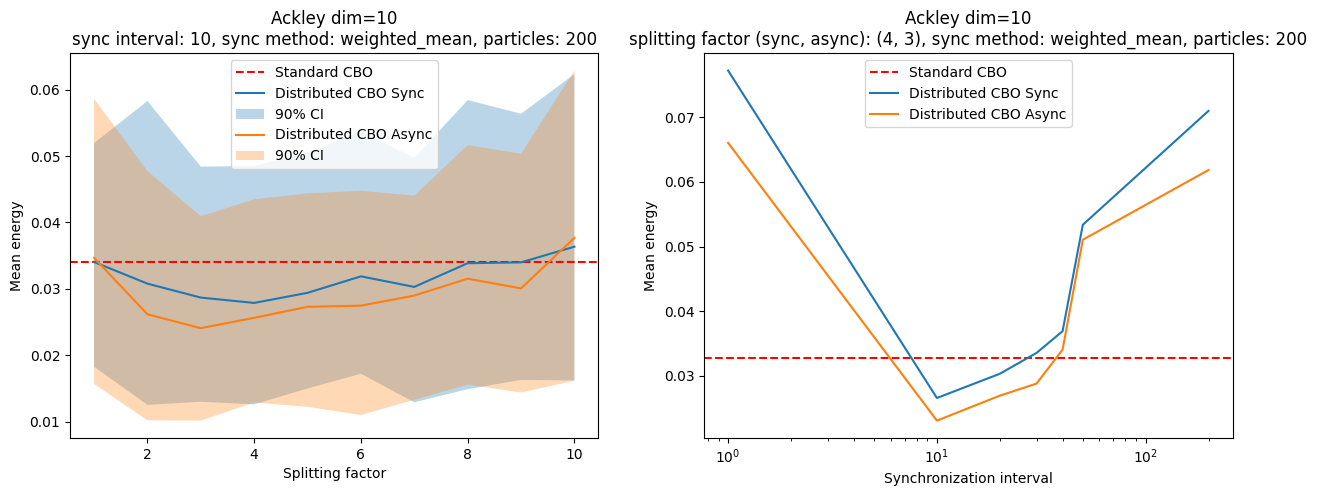

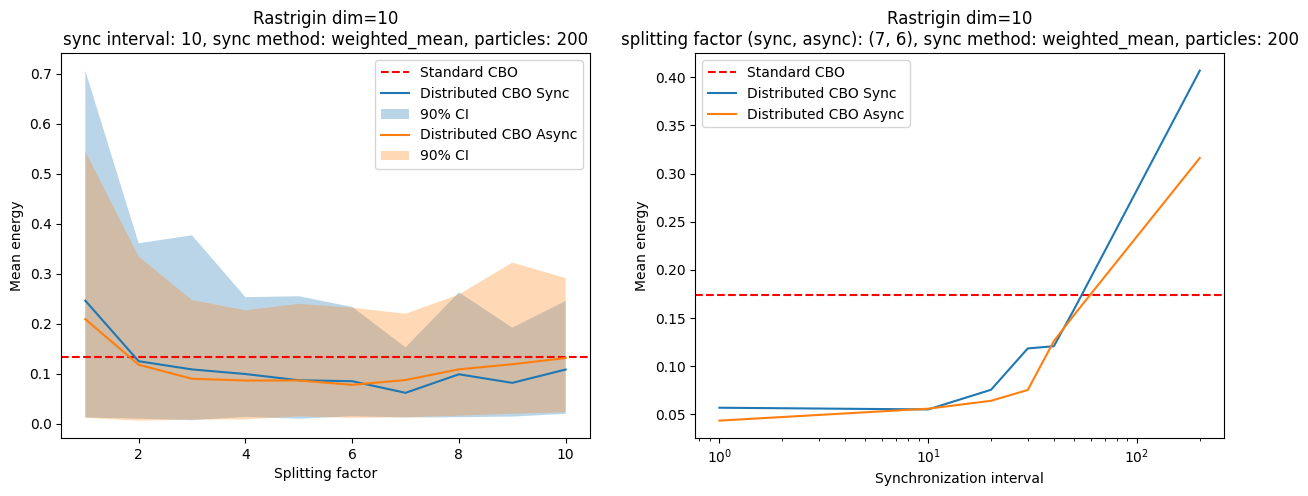

In [19]:
print("Ackley")
run_experiment(Ackley(), d=10, n=200)

print("Rastrigin")
run_experiment(Rastrigin(), d=10, n=200)

Ackley
Standard CBO:
Average energy: 0.12786723801894917, success_rate: 1.0, function evaluations: 20200.0, execution time: 0.016454255580902098

Distributed CBO (synchronous communication):
Splitting factor: 1, average energy: 0.13917089222418005, success_rate: 1.0, function evaluations: 20200.0, execution time: 0.02454643964767456
Splitting factor: 2, average energy: 0.10865042979866402, success_rate: 1.0, function evaluations: 20200.0, execution time: 0.02549763083457947
Splitting factor: 3, average energy: 0.10241590061802676, success_rate: 1.0, function evaluations: 20233.666666666668, execution time: 0.02899224519729614
Splitting factor: 4, average energy: 0.10528077905433655, success_rate: 1.0, function evaluations: 20225.25, execution time: 0.03556938588619232
Splitting factor: 5, average energy: 0.10647631994729899, success_rate: 1.0, function evaluations: 20220.2, execution time: 0.040339104175567624
Splitting factor: 6, average energy: 0.10767278642549268, success_rate: 1.0,

/var/folders/hm/3vrj0gkd6vlf68r7t8sqs86m0000gp/T/ipykernel_19112/3178628308.py:136: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Average energy: 0.6441041286342168, success_rate: 0.01, function evaluations: 20200.0, execution time: 0.017093863487243652

Distributed CBO (synchronous communication):
Splitting factor: 1, average energy: 0.7055930982617821, success_rate: 0.01, function evaluations: 20200.0, execution time: 0.026531808376312256
Splitting factor: 2, average energy: 0.4640511993361575, success_rate: 0.02, function evaluations: 20200.0, execution time: 0.026731215715408325
Splitting factor: 3, average energy: 0.4455570289809772, success_rate: 0.01, function evaluations: 20233.666666666668, execution time: 0.03083091735839844
Splitting factor: 4, average energy: 0.4576492690265271, success_rate: 0.0, function evaluations: 20225.25, execution time: 0.03618056356906891
Splitting factor: 5, average energy: 0.48146661693843823, success_rate: 0.0, function evaluations: 20220.2, execution time: 0.041826045036315915
Splitting factor: 6, average energy: 0.47286176673586366, success_rate: 0.0, function evaluation

/var/folders/hm/3vrj0gkd6vlf68r7t8sqs86m0000gp/T/ipykernel_19112/3178628308.py:136: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


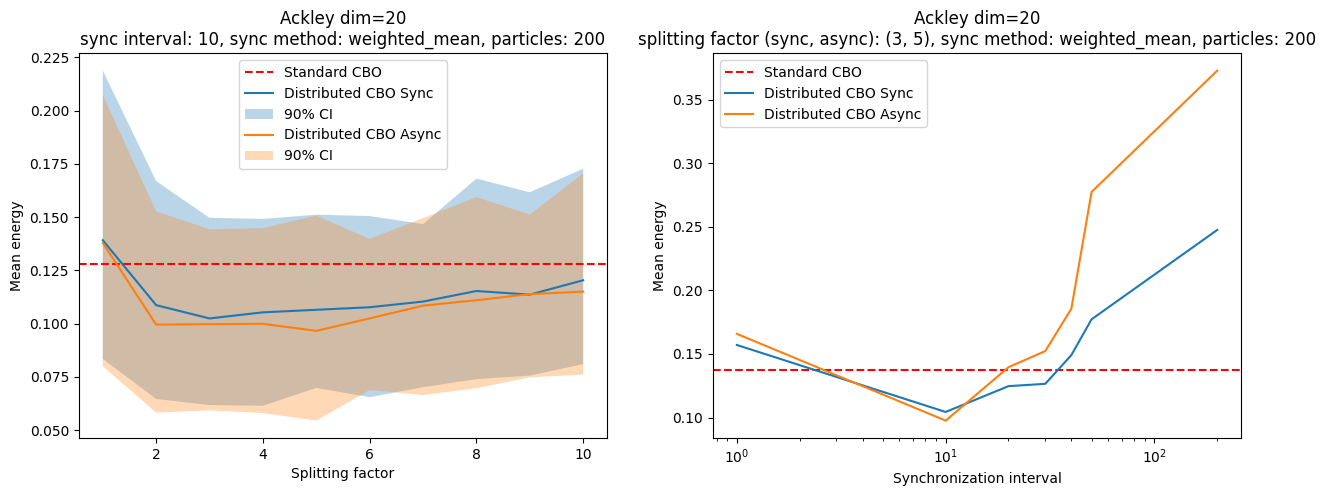

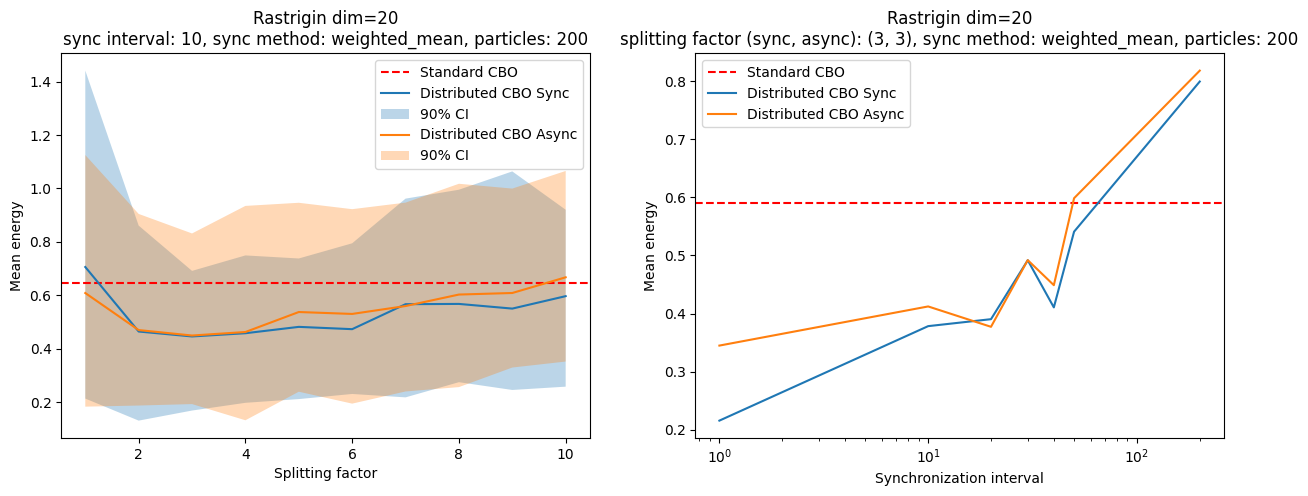

In [20]:
print("Ackley")
run_experiment(Ackley(), d=20, n=200)

print("Rastrigin")
run_experiment(Rastrigin(), d=20, n=200)

Ackley
Standard CBO:
Average energy: 0.002982768544586012, success_rate: 1.0, function evaluations: 101000.0, execution time: 0.026861681938171386

Distributed CBO (synchronous communication):
Splitting factor: 1, average energy: 0.0032935932193779572, success_rate: 1.0, function evaluations: 101000.0, execution time: 0.0320960259437561
Splitting factor: 2, average energy: 0.003461956391787293, success_rate: 1.0, function evaluations: 101000.0, execution time: 0.030853513479232788
Splitting factor: 3, average energy: 0.0030544459208222997, success_rate: 1.0, function evaluations: 101067.33333333333, execution time: 0.035968621571858726
Splitting factor: 4, average energy: 0.002933204799669209, success_rate: 1.0, function evaluations: 101050.5, execution time: 0.04122394442558289
Splitting factor: 5, average energy: 0.0024779698431057363, success_rate: 1.0, function evaluations: 101040.4, execution time: 0.04718431568145752
Splitting factor: 6, average energy: 0.0021454082657300865, suc

/var/folders/hm/3vrj0gkd6vlf68r7t8sqs86m0000gp/T/ipykernel_19112/3178628308.py:136: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Average energy: 0.000607503610887683, success_rate: 1.0, function evaluations: 101000.0, execution time: 0.02727701425552368

Distributed CBO (synchronous communication):
Splitting factor: 1, average energy: 0.0013820697338818952, success_rate: 1.0, function evaluations: 101000.0, execution time: 0.031882936954498294
Splitting factor: 2, average energy: 0.0009702582539439958, success_rate: 1.0, function evaluations: 101000.0, execution time: 0.030300495624542238
Splitting factor: 3, average energy: 0.0008135985265811349, success_rate: 1.0, function evaluations: 101067.33333333333, execution time: 0.033932215372721355
Splitting factor: 4, average energy: 0.0006697263039715154, success_rate: 1.0, function evaluations: 101050.5, execution time: 0.038465773463249205
Splitting factor: 5, average energy: 0.0006136211849073554, success_rate: 1.0, function evaluations: 101040.4, execution time: 0.044224295139312746
Splitting factor: 6, average energy: 0.0004884795578221527, success_rate: 1.0, 

/var/folders/hm/3vrj0gkd6vlf68r7t8sqs86m0000gp/T/ipykernel_19112/3178628308.py:136: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


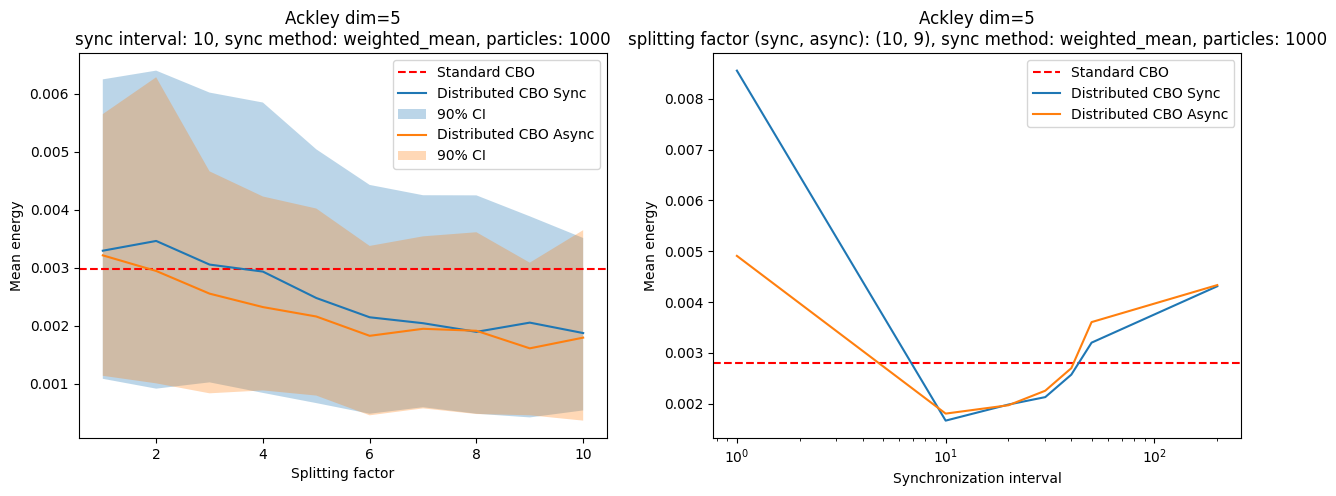

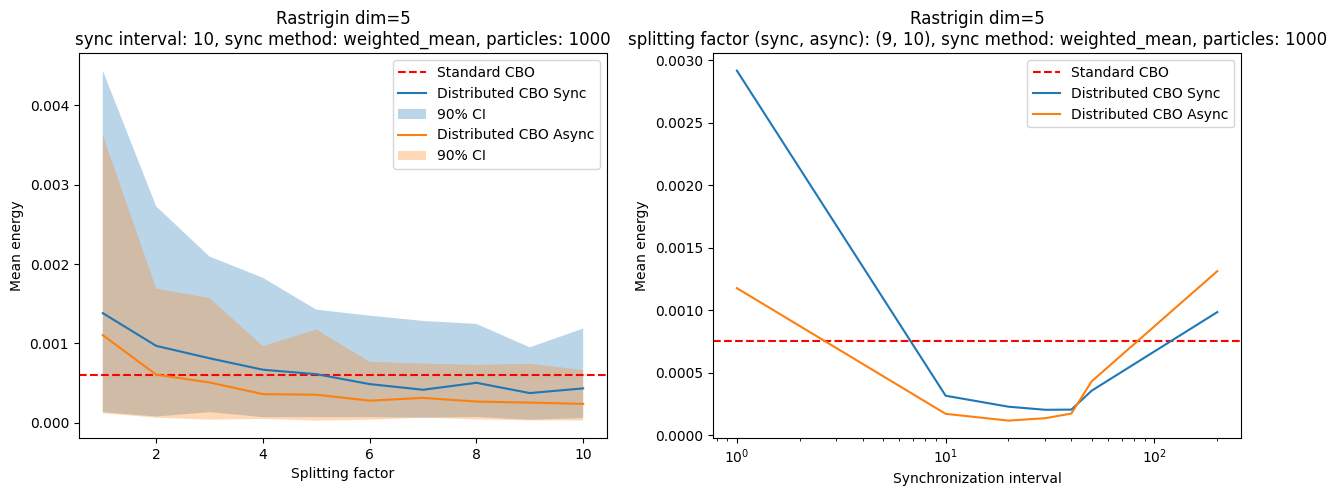

In [21]:
print("Ackley")
run_experiment(Ackley(), d=5, n=1000)

print("Rastrigin")
run_experiment(Rastrigin(), d=5, n=1000)

Ackley
Standard CBO:
Average energy: 0.01951985027455594, success_rate: 1.0, function evaluations: 101000.0, execution time: 0.03489615440368652

Distributed CBO (synchronous communication):
Splitting factor: 1, average energy: 0.019387106453419154, success_rate: 1.0, function evaluations: 101000.0, execution time: 0.04210766315460205
Splitting factor: 2, average energy: 0.016732625071284934, success_rate: 1.0, function evaluations: 101000.0, execution time: 0.041469013690948485
Splitting factor: 3, average energy: 0.013508052199978894, success_rate: 1.0, function evaluations: 101067.33333333333, execution time: 0.043457131385803226
Splitting factor: 4, average energy: 0.013340600485624935, success_rate: 1.0, function evaluations: 101050.5, execution time: 0.047520843148231504
Splitting factor: 5, average energy: 0.011997104694301175, success_rate: 1.0, function evaluations: 101040.4, execution time: 0.05280256557464599
Splitting factor: 6, average energy: 0.011428438873072775, success

/var/folders/hm/3vrj0gkd6vlf68r7t8sqs86m0000gp/T/ipykernel_19112/3178628308.py:136: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Average energy: 0.011126767676242457, success_rate: 1.0, function evaluations: 101000.0, execution time: 0.04234018564224243

Distributed CBO (synchronous communication):
Splitting factor: 1, average energy: 0.04625199970752772, success_rate: 1.0, function evaluations: 101000.0, execution time: 0.04715307474136352
Splitting factor: 2, average energy: 0.019259214505439028, success_rate: 1.0, function evaluations: 101000.0, execution time: 0.04531646728515625
Splitting factor: 3, average energy: 0.007071590508757406, success_rate: 1.0, function evaluations: 101067.33333333333, execution time: 0.04625005165735881
Splitting factor: 4, average energy: 0.005787531435347291, success_rate: 1.0, function evaluations: 101050.5, execution time: 0.04968059360980988
Splitting factor: 5, average energy: 0.0073065358261884825, success_rate: 1.0, function evaluations: 101040.4, execution time: 0.055020300388336184
Splitting factor: 6, average energy: 0.005980983259011704, success_rate: 1.0, function e

/var/folders/hm/3vrj0gkd6vlf68r7t8sqs86m0000gp/T/ipykernel_19112/3178628308.py:136: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


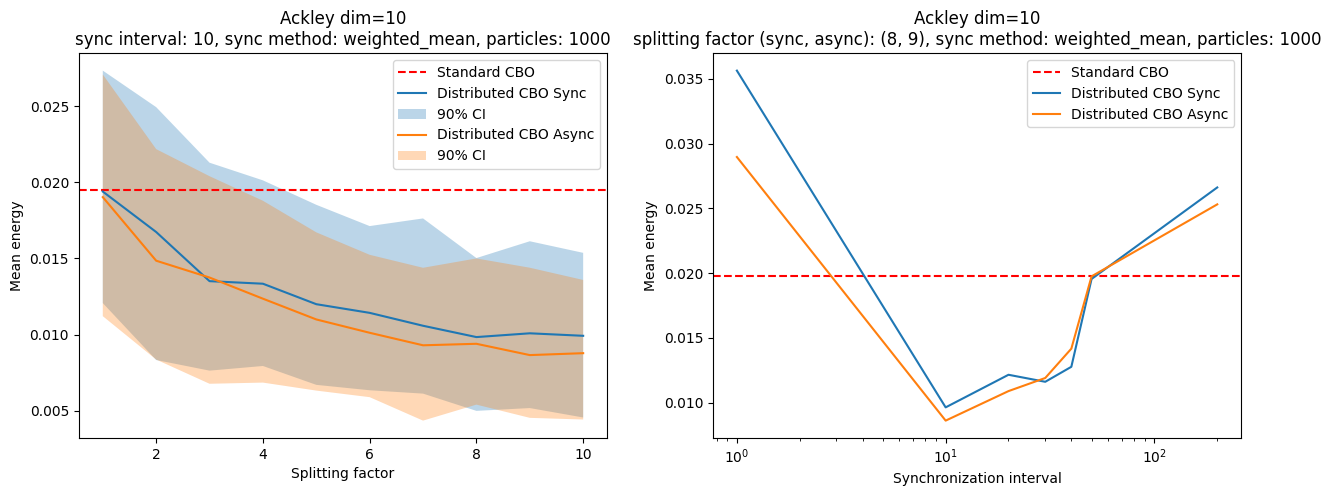

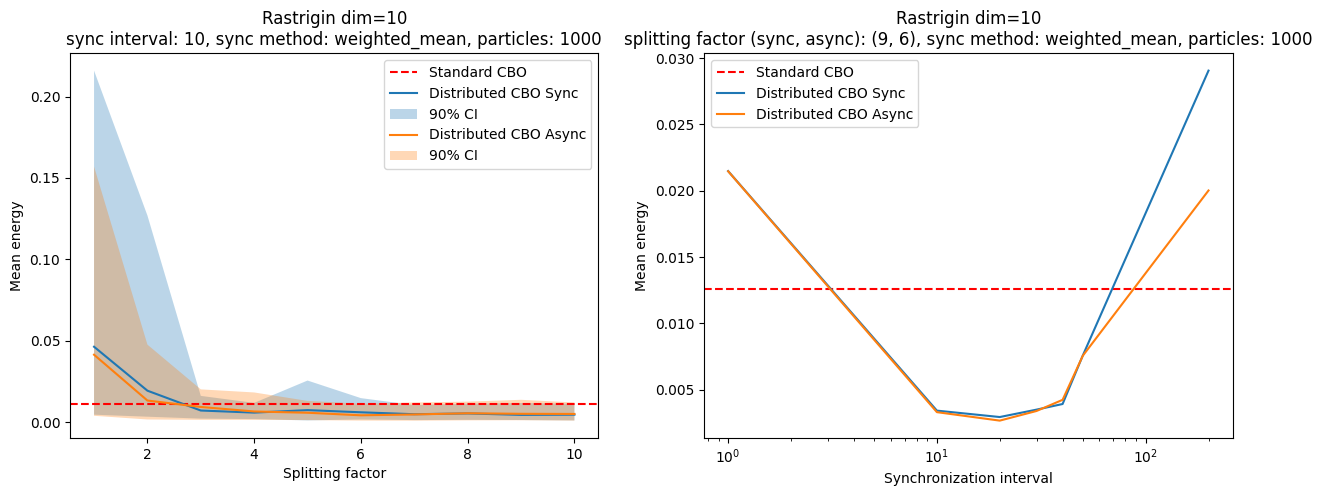

In [22]:
print("Ackley")
run_experiment(Ackley(), d=10, n=1000)

print("Rastrigin")
run_experiment(Rastrigin(), d=10, n=1000)

Ackley
Standard CBO:
Average energy: 0.05725236176537907, success_rate: 1.0, function evaluations: 101000.0, execution time: 0.0640495228767395

Distributed CBO (synchronous communication):
Splitting factor: 1, average energy: 0.057087300093733334, success_rate: 1.0, function evaluations: 101000.0, execution time: 0.06893250465393067
Splitting factor: 2, average energy: 0.04556741346451673, success_rate: 1.0, function evaluations: 101000.0, execution time: 2.977138692140579
Splitting factor: 3, average energy: 0.040802223239189445, success_rate: 1.0, function evaluations: 101067.33333333333, execution time: 2.008578186829885
Splitting factor: 4, average energy: 0.03751005578384186, success_rate: 1.0, function evaluations: 101050.5, execution time: 3.700039331316948
Splitting factor: 5, average energy: 0.03669863931325308, success_rate: 1.0, function evaluations: 101040.4, execution time: 2.978784688472748
Splitting factor: 6, average energy: 0.03519577300151793, success_rate: 1.0, func

/var/folders/hm/3vrj0gkd6vlf68r7t8sqs86m0000gp/T/ipykernel_19112/3178628308.py:136: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Average energy: 0.19724485196749408, success_rate: 0.22, function evaluations: 101000.0, execution time: 0.06455261707305908

Distributed CBO (synchronous communication):
Splitting factor: 1, average energy: 0.2093105852986058, success_rate: 0.3, function evaluations: 101000.0, execution time: 0.07925733804702759
Splitting factor: 2, average energy: 0.17327752390476167, success_rate: 0.34, function evaluations: 101000.0, execution time: 0.07137655735015869
Splitting factor: 3, average energy: 0.1490989350931206, success_rate: 0.41, function evaluations: 101067.33333333333, execution time: 1.0154141465822855
Splitting factor: 4, average energy: 0.11726904982265626, success_rate: 0.56, function evaluations: 101050.5, execution time: 1.381294077038765
Splitting factor: 5, average energy: 0.10377772361055207, success_rate: 0.56, function evaluations: 101040.4, execution time: 2.18916832113266
Splitting factor: 6, average energy: 0.11489114418260286, success_rate: 0.52, function evaluations

/var/folders/hm/3vrj0gkd6vlf68r7t8sqs86m0000gp/T/ipykernel_19112/3178628308.py:136: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


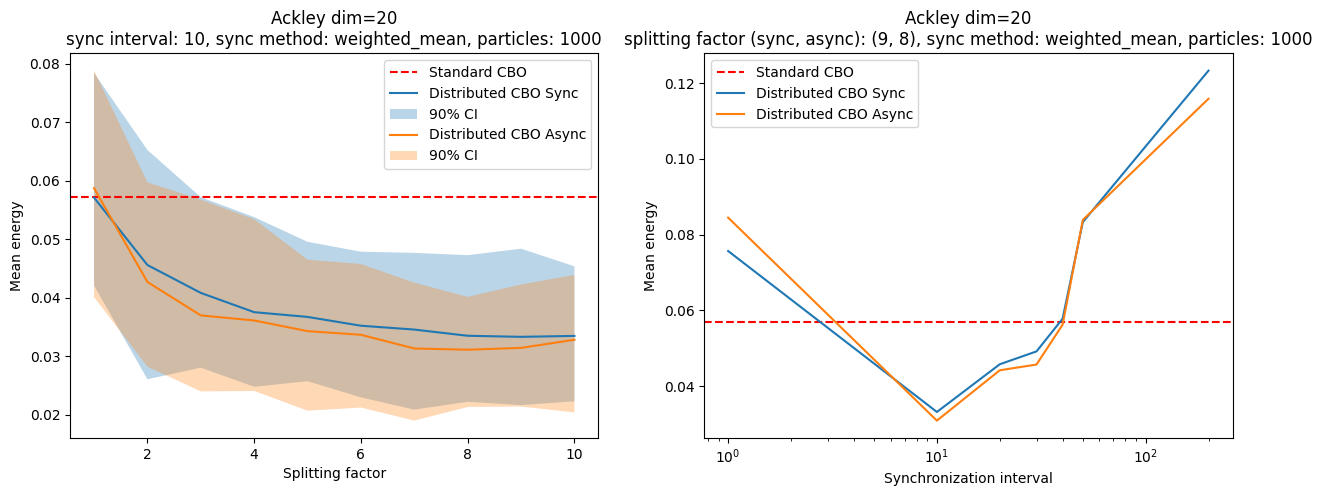

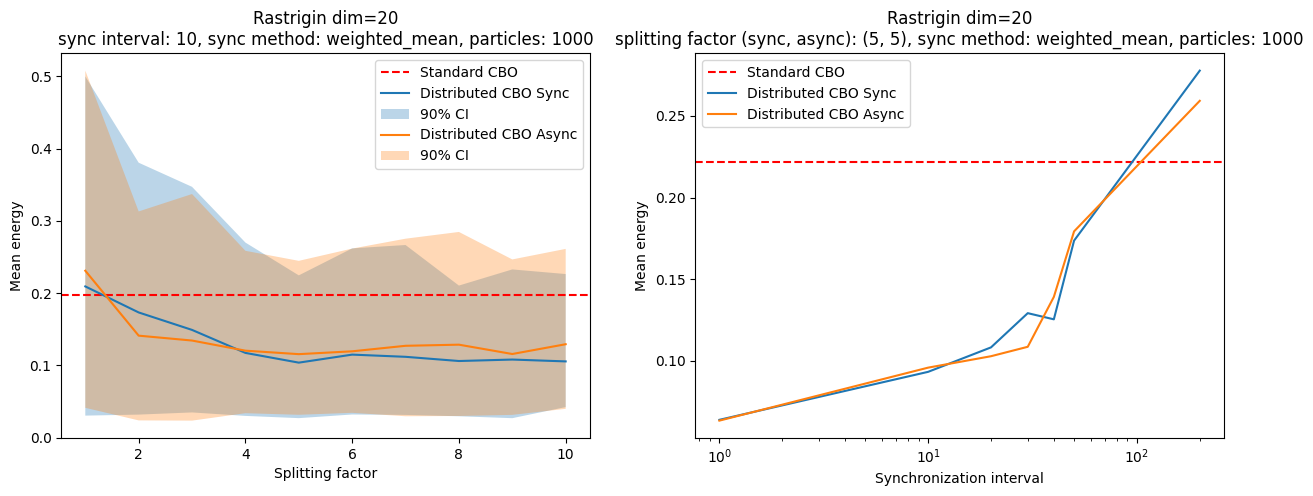

In [23]:
print("Ackley")
run_experiment(Ackley(), d=20, n=1000)

print("Rastrigin")
run_experiment(Rastrigin(), d=20, n=1000)

In [24]:
results_df

,fct_name,dim,async_communication,max_particles,splt_factor,avg_energy,success_rate,num_func_evaluations,execution_time,comment
0,Ackley,5,False,50,1,0.015364,1.00,5050.000000,0.006400,standard CBO
1,Ackley,5,False,50,1,0.023122,1.00,5050.000000,0.013281,distributed CBO
2,Ackley,5,False,50,2,0.023117,1.00,5050.000000,0.017933,distributed CBO
3,Ackley,5,False,50,3,0.025623,1.00,5083.666667,0.020516,distributed CBO
4,Ackley,5,False,50,4,0.029240,1.00,5125.750000,0.022735,distributed CBO
...,...,...,...,...,...,...,...,...,...,...
523,Rastrigin,20,True,1000,7,0.127107,0.53,101072.142857,0.106960,distributed CBO
524,Rastrigin,20,True,1000,8,0.128664,0.49,101063.125000,0.111366,distributed CBO
525,Rastrigin,20,True,1000,9,0.115735,0.55,101145.888889,0.116526,distributed CBO
526,Rastrigin,20,True,1000,10,0.129286,0.38,101131.300000,0.121597,distributed CBO


In [25]:
results_df.to_csv('results3.csv')

In [1]:
import pandas as pd

results_df = pd.read_csv('results3.csv')

In [18]:
fct_name = 'Rastrigin'
dim = 20
particles = 1000

print(f"Results for {fct_name} with dim={dim} and max_particles={particles}")
print()

mask = (results_df['fct_name'] == fct_name) & (results_df['dim'] == dim) & (results_df['max_particles'] == particles)# & (results_df['async_communication'] == async_communication)


table = results_df[mask].sort_values(by='splt_factor')
# if results have same splitting factor, take the one with the lowest energy
table = table.drop_duplicates(subset=['splt_factor', 'async_communication'], keep='first').sort_values(by=['splt_factor', 'async_communication'])


min_async = table[table['async_communication'] == True]['avg_energy'].min()
min_sync = table[table['async_communication'] == False]['avg_energy'].min()

# # format table like so:
# # \textbf for min_async and min_sync, respectively
"""
splitting factor & energy_sync & success rate_sync & energy_async & success rate_async\\
1 & \textbf{0.0171} & 0\% & 0.0184 & 0\% \\
2 & 0.0176 & 0\% & \textbf{0.0143} & 0\% \\
3 & 0.0213 & 0\% & 0.017 & 0\% \\
4 & 0.0223 & 0\% & 0.0208 & 0\% \\
5 & 0.0299 & 0\% & 0.0291 & 0\% \\
6 & 0.0309 & 0\% & 0.0299 & 0\% \\
7 & 0.0307 & 0\% & 0.0296 & 0\% \\
8 & 0.0402 & 0\% & 0.0356 & 0\% \\
9 & 0.0464 & 0\% & 0.0416 & 0\% \\
10 & 0.0529 & 0\% & 0.051 & 0\% \\
"""

for i in range(0, len(table), 2):
    sync_row = table.iloc[i]
    async_row = table.iloc[i + 1]

    assert sync_row['splt_factor'] == async_row['splt_factor']
    assert sync_row['async_communication'] == False and async_row['async_communication'] == True

    splitting_factor = sync_row['splt_factor']

    energy_sync = sync_row['avg_energy']
    success_rate_sync = sync_row['success_rate'] * 100

    energy_async = async_row['avg_energy']
    success_rate_async = async_row['success_rate'] * 100

    energy_sync_formatted = f"\\textbf{{{energy_sync:.4f}}}" if energy_sync == min_sync else f"{energy_sync:.4f}"
    energy_async_formatted = f"\\textbf{{{energy_async:.4f}}}" if energy_async == min_async else f"{energy_async:.4f}"

    print(f"{splitting_factor} & {energy_sync_formatted} & {success_rate_sync:.0f}\% & {energy_async_formatted} & {success_rate_async:.0f}\% \\\\")




Results for Rastrigin with dim=20 and max_particles=1000

1 & 0.1972 & 22\% & 0.2310 & 19\% \\
2 & 0.1733 & 34\% & 0.1411 & 40\% \\
3 & 0.1491 & 41\% & 0.1344 & 46\% \\
4 & 0.1173 & 56\% & 0.1204 & 52\% \\
5 & \textbf{0.1038} & 56\% & \textbf{0.1155} & 50\% \\
6 & 0.1149 & 52\% & 0.1195 & 52\% \\
7 & 0.1118 & 56\% & 0.1271 & 53\% \\
8 & 0.1060 & 53\% & 0.1287 & 49\% \\
9 & 0.1081 & 52\% & 0.1157 & 55\% \\
10 & 0.1055 & 57\% & 0.1293 & 38\% \\


In [78]:
results_df[(results_df["success_rate"] < 1) & (results_df["fct_name"] == "Ackley")]

,fct_name,dim,async_communication,max_particles,splt_factor,avg_energy,success_rate,num_func_evaluations,execution_time,comment
88,Ackley,20,False,50,1,0.450069,0.99,5050.0,0.008493,standard CBO


In [79]:
success_epsilons

{('Ackley', 5): np.float64(1.6462236331031233),
 ('Rastrigin', 5): np.float64(0.39798362283732164),
 ('Ackley', 10): np.float64(1.155148502709889),
 ('Rastrigin', 10): np.float64(0.5969754342560046),
 ('Ackley', 20): np.float64(1.1551485027099564),
 ('Rastrigin', 20): np.float64(0.0994959057093337)}